### Sound Generation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title ##### Import libraries
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from IPython.display import Javascript, display
from ipywidgets import widgets
import json
import pandas as pd
import operator
import joblib
import librosa
import soundfile as sf
import shutil
#from collections import Counter
import numpy as np
import random
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import load_model

import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

print(tf.config.list_physical_devices('GPU'))


%cd /content/drive/MyDrive/CODE/CondVAEmelspec/

from musicnn_tags import musicnn_tags as musicnn_tags_all

[]
/content/drive/MyDrive/CODE/CondVAEmelspec


In [ ]:
MODEL_PATH = "/content/drive/MyDrive/CODE/CondVAEmelspec/models/simple_vae/"
SPECTROGRAMS_PATH = "/content/drive/MyDrive/CODE/CondVAEmelspec/data/spectrograms/"
TAGS_PATH = "/content/drive/MyDrive/CODE/CondVAEmelspec/data/tags/"

In [ ]:
#@title #### load training params
# load training params
with open(os.path.join(MODEL_PATH, 'training_params.json')) as json_file:
    params = json.load(json_file)

for k, v in params.items():
    print(k,v)

DATASET 5000
BATCH_SIZE 256
LATENT_DIM 64
LEARNING_RATE 0.001
EPOCHS 5000
INPUT_SHAPE 18048
CONDITION_SIZE 26
LABELS ['classical', 'guitar', 'rock', 'drums', 'weird', 'indian', 'strings', 'harpsichord', 'electronic', 'techno', 'flute', 'piano', 'vocal', 'violin', 'sitar', 'female', 'choir', 'male', 'synth', 'beat', 'slow', 'ambient', 'quiet', 'fast', 'loud', 'harp']


In [ ]:
#@title #### load labels encoder, min_max_scaler
le_path = os.path.join(MODEL_PATH, "label_encoder.joblib")
le = joblib.load(le_path)

min_max_scaler_path = os.path.join(MODEL_PATH, "min_max_scaler.joblib")
min_max_scaler = joblib.load(min_max_scaler_path)

In [ ]:
#@title #### load the models
encoder = load_model( os.path.join(MODEL_PATH, 'encoder.h5'), compile=False)
decoder = load_model( os.path.join(MODEL_PATH, 'decoder.h5'), compile=False)
vae = load_model( os.path.join(MODEL_PATH, 'vae.h5'), compile=False)

In [ ]:
#@title #### set params
SR = 16000 #22050
FFT_HOP = 256
FFT_SIZE = 512
N_MELS = 96
N_ITER = 32

In [ ]:
#@title #### audio utils
def mel2audio(signal, save=False):

    signal = min_max_scaler.inverse_transform(signal)

    plt.imshow(signal)

    # convert melspec back to audio
    # Invert mel-spectrogram
    S_inv = librosa.feature.inverse.mel_to_stft(signal, sr=SR, n_fft=FFT_HOP*4)
    y = librosa.griffinlim(S_inv, n_iter=N_ITER, hop_length=FFT_HOP)
    
    duration = librosa.get_duration(y=y, sr=SR)
    
    if save:
      filename = ''.join(random.choice(letters) for i in range(10))
      path = os.path.join(GEN_PATH, 'j' + '.wav')
      sf.write(path, y, SR, 'PCM_24')
    
    return y

def mel2audio(mel):

    y = librosa.feature.inverse.mel_to_audio(mel, 
                                         sr=SR, 
                                         n_fft=FFT_SIZE, 
                                         hop_length=FFT_HOP, 
                                         win_length=FFT_SIZE, 
                                         window='hann', 
                                         center=True, 
                                         pad_mode='reflect', 
                                         power=2.0, 
                                         n_iter=32, 
                                         length=None)
    
    return y


def audio2mel(audio):
  # TODO
  pass


In [ ]:
#@title Select a label and generate a sample

from IPython.display import Javascript
Javascript('IPython.notebook.execute_cells_below()')

w = widgets.Dropdown(
    options=params['LABELS'],
    value='techno',
    description='label',
)

display(w)

Dropdown(description='label', index=9, options=('classical', 'guitar', 'rock', 'drums', 'weird', 'indian', 'st…

Generating sample with tag: harp 

10


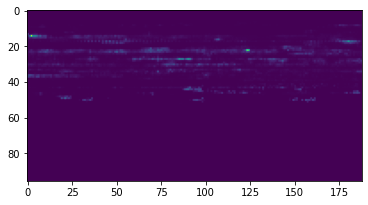

In [ ]:
#@title 
lab = w.value
print('Generating sample with tag:', lab, '\n')

# cond vec
cond_vec = le.transform([lab])
tag_index = np.where(cond_vec == 1)[1][0]
print(tag_index)
cond_vec = np.random.uniform(low=0, high=0.99, size=(1, params['CONDITION_SIZE']))
cond_vec[0][tag_index] = 1

# z
#z_sample = tf.random.normal(shape=(params['CONDITION_SIZE'], params['LATENT_DIM']))

z_sample = np.random.uniform(low=0, high=2.5, size=(params['CONDITION_SIZE'], params['LATENT_DIM']))


# gen
generated = decoder.predict([z_sample, np.repeat(cond_vec, params['CONDITION_SIZE'], axis=0)], steps=1)\
            .reshape(params['CONDITION_SIZE'], 96, 188)

#print(generated.shape)

idx = 0

signal = generated[idx,:,:]

y = mel2audio(signal)
ipd.Audio(y, rate=SR)

#### Input a melspec and condition the generation on another tag

musicnn tag: techno 



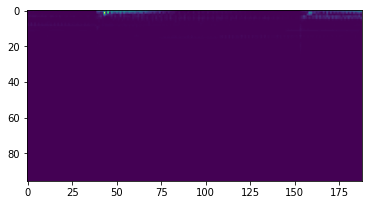

In [ ]:
melspecs = os.listdir(SPECTROGRAMS_PATH)
melspecs = [i for i in melspecs if '.npy' in i]

idx = 20 #19 #11

X = []

spec_file = os.path.join(SPECTROGRAMS_PATH, melspecs[idx])
arr = np.load(spec_file)

tags_file = os.path.join(TAGS_PATH, melspecs[idx])
v = np.load(tags_file)

# take top N tags only
v = list(v)
d = dict(zip(musicnn_tags_all, v))
D = dict(sorted(d.items(),key=operator.itemgetter(1),reverse=True))
tags = list(D.keys())[:1][0]

print('musicnn tag:', tags, '\n')

if arr.shape == (96, 188):
  X.append(arr)

X = np.array(X)

X = min_max_scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

y = mel2audio(X[0])
ipd.Audio(y, rate=SR)

[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(1, 96, 188)


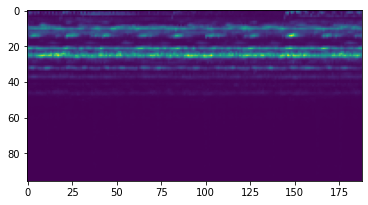

In [ ]:
# predict its embedding and condition on another tag

# reshape
X2 = X.reshape(X.shape[0], -1).astype('float32') #/ 255

cond_label = 'drums'
cond_label = 'choir' #'drums'
cond_label = 'female'
condition = le.transform([cond_label])
condition = np.array(condition)

#z_sample = tf.random.normal(shape=(CONDITION_SIZE, LATENT_DIM))
#condition = np.random.uniform(low=0, high=2, size=(1, params['CONDITION_SIZE']))
print(condition)

# todo replace 1 where tag
#condition = np.insert(condition[0], tag_index, 1)
#print(condition.shape)

generated = vae.predict([X2, condition]).reshape(1, 96, 188)

print(generated.shape)

y = mel2audio(generated[0]) #.reshape(1, -1)
ipd.Audio(y, rate=SR)